### First Heuristic - Preliminary implementation

#### Description
If a deposit address matches a withdraw address, then it is trivial to link the two addresses. Therefore, the deposit address needs to be removed from all the other withdraw addresses’ anonymity set. 
If a number $N$ of deposits with a same address $add1$, and a number $M$ ($M < N$) of withdraws with that same aaddress are detected, then a number $M - N$ of deposit transactions must be removed from the anonimity set of all the other withdraw transactions.


In [1]:
# Import relevant packages.

using DataFrames
using CSV
using StatsPlots
using ProgressBars

In [5]:
# Environment settings for the notebook.
ENV["LINES"]=10
ENV["COLUMNS"]=10000

10000

In [3]:
# Load withdraw and deposit transactions data.

withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
withdraw_transactions_df[!, "recipient_address"] = lowercase.(withdraw_transactions_df[!, "recipient_address"])

deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame);

In [6]:
withdraw_transactions_df

,Column1,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address
,Int64,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Float64?,Float64?,Float64?,Int64,String,String
1,0,7,0x3dc8617176f45c0f33a95589c202b22f9ba8aa7067bb92887517e20b237907e3,789,196,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0xa160cdab225685da1d56aa342ad8841c3b53f291,0,386384,121000000000,10382378,336384,missing,missing,1,2020-10-05 07:57:28 UTC,10994498,0xa96abb653dd6d4e3cedd6bd65fd0a7b034e4c9527be91cb80ee62d790714ab49,missing,missing,missing,121000000000,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xd843ce0f9da3bd30537b9850711ab8089e06b4cf
2,1,8,0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da7251d2d2a0a794038d0d,9,190,0xb77562124be8ac967cf7fc24573fe252aa39d95d,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13000000000,7303106,339456,missing,missing,1,2020-02-11 19:10:54 UTC,9463504,0x1e1dc9cec82d1dcd0e68e60968d180408007e148ac065261de232dc502dfb756,missing,missing,missing,13000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0xb77562124be8ac967cf7fc24573fe252aa39d95d
3,2,9,0x95a46a1305ddc8b7e01d82c7d6766fce4713c085929f70c9a24e90f927672699,2,81,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13200000000,3211601,339456,missing,missing,1,2020-02-16 16:05:14 UTC,9495139,0x1f0562c98f40f0689ed8bac422b4714289bd452d9290928b30f7defe0943381f,missing,missing,missing,13200000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c
4,3,13,0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad11b91faa77bb852599b76,2024,189,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,384581,40000000000,11795370,343296,missing,missing,1,2020-11-09 17:08:00 UTC,11224582,0xe0ae8902495001fc28025238a74703c1b3d58282aaeef5fd5ca3fe9cb2d273ff,missing,missing,missing,40000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x42a9cf901e889ca8a685394854c27898dbff86b0
5,4,15,0x30becee80e63a039102df3b1243e5d314534abfcf3ed0fc4eadb2dc5b1c45ab7,2350,127,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,15020000842,9771737,354304,missing,missing,1,2020-11-29 01:18:57 UTC,11350558,0x4d8f724d2bdffa546cef74d21c6c43968b566b67318e2f737a7c6b26b8781e56,missing,missing,missing,15020000842,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xc9fb4b16800e61076326145e1066e876cf9f7a7b
6,5,16,0x5ef2e6d75efa800f009a84b27ae22609597edee8df8ee8699c004af233cf5855,999,120,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,72000000000,8783549,354304,missing,missing,1,2020-10-11 18:09:09 UTC,11035787,0xb18729068418804f6c247b13e92236035f8303c43828c59d70b279166ca4f67a,missing,missing,missing,72000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x9453663da4123648bd00cb5600b97a4314ad0058
7,6,17,0x59d6d259118b41170550e5662c35b20c1b8ba795e420f6ce7a74772a9a834492,550,86,0x41a28335c5075c81502a97cebad597f28728a815,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0,404304,26000000000,4476696,354304,missing,missing,1,2020-05-26 22:55:55 UTC,10144176,0xd22e4252818d56d9a7b4bb6c7488842877db42771a497f175ba78cd7a1aa00c1,missing,missing,missing,26000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xd01ad76a2337354dd458fcbb6e507e001f06b77d
8,7,42,0x805b2ae79b5267a23e6c79d3324d43dae0f64e81f77f166c09dca9ff46cfc955,260,128,0xefab18983029d2ba840e34698efb67fdf8120711,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0,383057,5050000000,7284273,333057,missing,missing,1,2020-02-04 13:43:11 UTC,9416438,0x644ea6d8f078b89696758c59f74f93f0f226838593a79bcb9980f5815e023cbb,missing,missing,missing,5050000000,0x12d66f87a04a9e22074

In [7]:
deposit_transactions_df

,Column1,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address
,Int64,Int64,String,Int64,Int64,String,String,Float64,Int64,Int64,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Float64?,Float64?,Float64?,Int64,String
1,0,0,0xcf97c470a56d96625c7240d3004ae2abd9141d7ffc4383ab6f29a181e3562e8b,4,10,0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,56000000000,1677906,1048832,missing,missing,1,2020-11-02 17:47:30 UTC,11179130,0x21d86cba454fea4f7e43c68763d4cffec101b614554635a3f15d538049463d4f,missing,missing,missing,56000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d
2,1,1,0x2fadc4d54bf6e3ec5035f14c0096befe92999866309893e0eeaecdef955c0323,22,118,0x6e92bc493c6abbdd6a1b18416f003de2c873ab50,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0.0,1200000,63000000000,8209080,1048832,missing,missing,1,2021-01-02 23:37:35 UTC,11578054,0xd52ababd1dbbbe50277c54473c881f47fd95e78081a349670d4988644e4d37c4,missing,missing,missing,63000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d
3,2,10,0x7baf0a76f35c1dece97fff883aa7174454bed460b1bade05844080017170fc6c,240,171,0x8c4c44fd06f7f98f08bf6a9ca156cec9ee1f31f8,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,0.0,800000,105000000000,10723996,800000,missing,missing,0,2021-01-06 19:04:40 UTC,11602841,0x7c5f21ea2a92f5182ce8648f152b6fb3b4379096309dc2ba232ac663c4a0d1d7,missing,missing,missing,105000000000,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144
4,3,11,0x7f851ba1d7292ca565961073a1111f7408760540c6f94e479c72a2ae05399cf4,0,84,0x50b9d4af009b038506d4d84b035c451d1a3a20bc,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,5000000000,8465851,800000,missing,missing,0,2020-01-05 05:19:39 UTC,9218451,0x77e0fc60906714a54697cfd9275b622ad9d2d0271c4ec816b10fa3a09b103680,missing,missing,missing,5000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc
5,4,12,0xbd83053f8afa7777f54a4aca6b8e112fa31b888922dc5b9a9a65eb66e9a6996f,7,63,0x6c6e4816ecfa4481472ff88f32a3e00f2eaa95a1,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,800000,30838446643,6222489,800000,missing,missing,0,2020-05-27 03:30:44 UTC,10145408,0x837b3482443f027f6f045644bf002243f72304686015a2d6265676b2a2fc630b,missing,missing,missing,30838446643,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc
6,5,14,0x76b09da7f41e24cba38a1e6685c1e59e7eeb476b6ba037c117a7507c7893d997,17,192,0x23480df691dbf7c62e967952bbf2067c18cc2f16,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144,0.0,1200000,20000000000,10862643,1009408,missing,missing,1,2020-07-14 22:31:59 UTC,10460353,0x5fb59dbf5a00a59e074b3157380ed5cf0cf25db54023d9e030fe752fcbffd1bd,missing,missing,missing,20000000000,0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144
7,6,65,0x28d7c0e186ba6e0fee6606821edce1b67c8efbc28fa9649226a36d884dbbb31e,34,122,0x5ba446670288149052645705618f121af76dd19d,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,1.0e17,100000,105000000000,11286350,99841,missing,missing,0,2020-09-23 18:37:27 UTC,10920500,0x5e10e5e65d15b9c79ebd8c3975d06a024565e8e4ae33b335527335677c4f0a7b,missing,missing,missing,105000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc
8,7,129,0x31cde8a6a7027377d821fd3e90b41ef5d07578b8a6e2127c65a2f6bdb0186375,447,16,0xd0698d231d4b65b97a3df9c16aafda8d9b0bda41,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f,0.0,1200000,99000000000,2127258,992258,missing,missing,1,2020-10-29 17:08:33 UTC,11152937,0x96aec1cd89b9e37fbeacca4a0ee33d6c2c71d02e3fd02b754fd78b8f4e7ce8fa,missing,missing,missing,99000000000,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f
9,8,130,0xba7d56fea776705a937d912674cc56cf3ea71485c8fb6995d1c2ec00d44645fc,2,69,0x3a456bc9083bfe147719504aee8f296eb7355ee1,0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f,0.0,1200000,100000000000,4634190,992258,missing,missing,1,2020-08-15 11:34:23 UTC,10664413,0x4075362cd93950

### Function summary: same_deposit_and_recipient_addresses_heuristic

The function receives a particular withdraw transaction and the entire deposit transactions data.

It returns a tuple:
* (true, list_of_same_address_deposit_hashes): When same address deposits are found, this tuple is returned. In the first element a boolean true, and the second is a list with all the deposit hashes that verify having the same address as the withdraw transaction.
* (false, nothing): When no such deposit was found.


In [4]:
function same_deposit_and_recipient_addresses_heuristic(withdraw_transaction, deposit_transactions_df)
    
    # Initialize empty array for storing deposit hashes that have the same address as the witdhraw.
    
    same_deposit_address_hashes = []
    
    # Iterate over each deposit transaction. When a matching deposit is found, its hash is pushed to
    # the list same_deposit_address_hashes.
    
    for deposit_row in eachrow(deposit_transactions_df)
        # Check that addresses are the same and that the deposit was done earlier than the withdraw.
        if (deposit_row.from_address == withdraw_transaction.recipient_address) &&
            (deposit_row.block_timestamp < withdraw_transaction.block_timestamp) &&
            (deposit_row.tornado_cash_address == withdraw_transaction.tornado_cash_address) 
            push!(same_deposit_address_hashes, deposit_row.hash)
        end
    end
    
    # If the list is empty, return (false, nothing). Else, return (true, same_deposit_address_hashes)
    
    isempty(same_deposit_address_hashes) ? (false, nothing) : (true, same_deposit_address_hashes)
end 

same_deposit_and_recipient_addresses_heuristic (generic function with 1 method)

### Function summar: apply_same_deposit_and_recipient_addresses_heuristic

Receives the withdraw and deposit transactions, and applies the first heuristic for each withdraw transaction.
Returns a dictionary, with keys as the hash of each withdraw transaction were a same deposit address was detected. The values are the hashes of all deposits matching this criteria.

In [9]:
function apply_same_deposit_and_recipient_addresses_heuristic(withdraw_transaction_df, deposit_transactions_df)
    
    # Initialize an empty dictionary for storing the links between withdraw hashes and deposit hashes with the 
    # same address.
    
    same_deposit_address_hashes = Dict()
    
    # Iterate over the withdraw transactions and apply heuristic one. For each withdraw with matching deposit
    # transactions, a new element is added to the dictionary with the key as the withdraw hash and the values
    # as all matching deposit hashes.
    
    for withdraw_row in ProgressBar(eachrow(withdraw_transaction_df), printing_delay=5)
        deposit_hashes = same_deposit_and_recipient_addresses_heuristic(withdraw_row, deposit_transactions_df)
        if deposit_hashes[1]
            same_deposit_address_hashes[withdraw_row.hash] = deposit_hashes[2]
        end
    end
    
    # Return the dictionary with the links
    
    return same_deposit_address_hashes
end

apply_same_deposit_and_recipient_addresses_heuristic (generic function with 1 method)

In [11]:
@time dict = apply_same_deposit_and_recipient_addresses_heuristic(withdraw_transactions_df, deposit_transactions_df);

0.0%┣                                     ┫ 0/83.8k [00:05<-116:-21:-50, -5s/it]
0.0%┣                                        ┫ 1/83.8k [00:05<Inf:Inf, InfGs/it]
0.3%┣▏                                         ┫ 268/83.8k [00:10<52:18, 27it/s]
0.7%┣▎                                         ┫ 551/83.8k [00:15<37:55, 37it/s]
1.0%┣▍                                         ┫ 798/83.8k [00:20<34:47, 40it/s]
1.2%┣▌                                        ┫ 1.0k/83.8k [00:25<33:04, 42it/s]
1.6%┣▋                                        ┫ 1.3k/83.8k [00:30<31:24, 44it/s]
1.9%┣▊                                        ┫ 1.6k/83.8k [00:35<30:18, 45it/s]
2.2%┣█                                        ┫ 1.9k/83.8k [00:40<29:29, 46it/s]
2.5%┣█                                        ┫ 2.1k/83.8k [00:45<28:51, 47it/s]
2.9%┣█▏                                       ┫ 2.4k/83.8k [00:50<28:20, 48it/s]
3.2%┣█▎                                       ┫ 2.7k/83.8k [00:55<27:55, 48it/s]
3.5%┣█▍                     

31.9%┣████████████▍                          ┫ 26.7k/83.8k [08:31<18:10, 52it/s]
32.2%┣████████████▋                          ┫ 27.0k/83.8k [08:36<18:06, 52it/s]
32.5%┣████████████▊                          ┫ 27.2k/83.8k [08:41<18:02, 52it/s]
32.8%┣████████████▉                          ┫ 27.5k/83.8k [08:46<17:58, 52it/s]
33.1%┣█████████████                          ┫ 27.7k/83.8k [08:51<17:53, 52it/s]
33.4%┣█████████████                          ┫ 28.0k/83.8k [08:56<17:49, 52it/s]
33.7%┣█████████████▏                         ┫ 28.2k/83.8k [09:01<17:45, 52it/s]
34.0%┣█████████████▎                         ┫ 28.5k/83.8k [09:06<17:41, 52it/s]
34.3%┣█████████████▍                         ┫ 28.7k/83.8k [09:11<17:36, 52it/s]
34.6%┣█████████████▌                         ┫ 29.0k/83.8k [09:16<17:32, 52it/s]
34.9%┣█████████████▋                         ┫ 29.2k/83.8k [09:21<17:28, 52it/s]
35.2%┣█████████████▊                         ┫ 29.5k/83.8k [09:26<17:24, 52it/s]
35.5%┣█████████████▉        

63.2%┣████████████████████████▋              ┫ 53.0k/83.8k [17:02<09:54, 52it/s]
63.6%┣████████████████████████▉              ┫ 53.2k/83.8k [17:07<09:49, 52it/s]
63.9%┣█████████████████████████              ┫ 53.5k/83.8k [17:12<09:44, 52it/s]
64.2%┣█████████████████████████              ┫ 53.8k/83.8k [17:17<09:39, 52it/s]
64.5%┣█████████████████████████▏             ┫ 54.0k/83.8k [17:22<09:34, 52it/s]
64.8%┣█████████████████████████▎             ┫ 54.3k/83.8k [17:27<09:30, 52it/s]
65.1%┣█████████████████████████▍             ┫ 54.5k/83.8k [17:32<09:24, 52it/s]
65.4%┣█████████████████████████▌             ┫ 54.8k/83.8k [17:37<09:19, 52it/s]
65.7%┣█████████████████████████▋             ┫ 55.1k/83.8k [17:42<09:14, 52it/s]
66.0%┣█████████████████████████▊             ┫ 55.3k/83.8k [17:47<09:09, 52it/s]
66.4%┣█████████████████████████▉             ┫ 55.6k/83.8k [17:53<09:04, 52it/s]
66.7%┣██████████████████████████             ┫ 55.9k/83.8k [17:58<08:59, 52it/s]
67.0%┣██████████████████████

95.6%┣█████████████████████████████████████▎ ┫ 80.1k/83.8k [25:33<01:10, 52it/s]
96.0%┣█████████████████████████████████████▍ ┫ 80.4k/83.8k [25:38<01:05, 52it/s]
96.3%┣█████████████████████████████████████▌ ┫ 80.7k/83.8k [25:43<01:00, 52it/s]
96.6%┣█████████████████████████████████████▊ ┫ 80.9k/83.8k [25:48<00:55, 52it/s]
96.9%┣█████████████████████████████████████▉ ┫ 81.2k/83.8k [25:53<00:49, 52it/s]
97.2%┣██████████████████████████████████████ ┫ 81.5k/83.8k [25:58<00:44, 52it/s]
97.5%┣██████████████████████████████████████ ┫ 81.7k/83.8k [26:03<00:39, 52it/s]
97.9%┣██████████████████████████████████████▏┫ 82.0k/83.8k [26:08<00:34, 52it/s]
98.2%┣██████████████████████████████████████▎┫ 82.3k/83.8k [26:13<00:29, 52it/s]
98.5%┣██████████████████████████████████████▍┫ 82.5k/83.8k [26:18<00:24, 52it/s]
98.8%┣██████████████████████████████████████▌┫ 82.8k/83.8k [26:23<00:19, 52it/s]
99.1%┣██████████████████████████████████████▋┫ 83.0k/83.8k [26:28<00:14, 52it/s]
99.4%┣██████████████████████

1597.636247 seconds (40.71 G allocations: 606.610 GiB, 6.67% gc time)


100.0%┣██████████████████████████████████████┫ 83.8k/83.8k [26:43<00:00, 52it/s]


In [9]:
# Count of deposit transactions linked to withdraws.

linked_deposits_count = map(x -> length(x), values(dict));

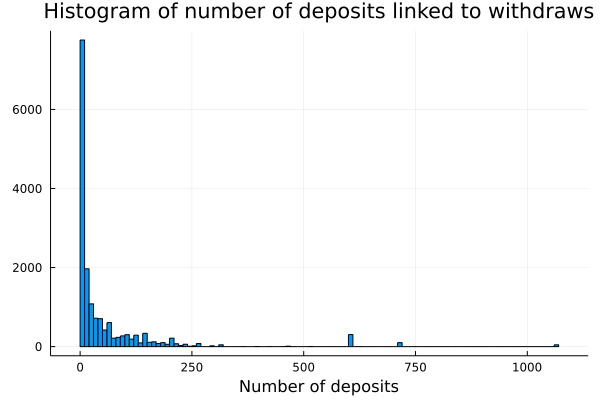

In [10]:
histogram(linked_deposits_count, bins=100, legend=false,
    title="Histogram of number of deposits linked to withdraws",
    xlabel="Number of deposits")

In [12]:
dict

Dict{Any, Any} with 14283 entries:
  "0xaf365abb6000eb05a6311d6b6f10132edc080a8624ee0feebeaf70c542e7f6e9" => Any["0xdbc727be9136da0339d3e1fa7a2233d9b55980ee61c97f3ca86f58a7801c8c57", "0x9a1cd26312b5ce8b156ae6ce5356f07ce64407a445c1c929718453eb01ec0e8d", "0x32c634693828d82da9744b7b37cdca7aefdab7ccfeec10a847a45b6c9ebf161b", "0x287abfabee09241ee3c61ceee9bcfd7cfd6025a336e0df97ddfb21a16006103a", "0x0078eaa83c1846ec02bc495aad5696d87ec46fee682074d7b1bb3d14a3d59e65", "0x280fa2522440220c4982614aea1ee7830085b0b81d7ed29eb1ceebc8c9184e8b", "0x93d0d623d8c92b2269627f9bd546630e6ba9585c95120dfaa80655aaeeaa9a7e", "0x6def453905b0a2e7809e2e79d173898fd38678b2df23ac1e59308c5296fbdc33", "0x355bcb2900859b6422b2ec92cb943e76e7cbda80573b477cb485a56bed2d7f46", "0x69f0df45a578d443f8f8150656351282b7a4e29f376b12222683d842aea997d0"  …  "0x981e2a46ccbbd994f0d4b9f596c24892d4daf159c9abbe75d5c275d931735979", "0x548965327e968187048d3245823a253865c0be18a3314c2a19978c6fd804a3ba", "0xf54a6a298e5e44a3e7fa2bd34fe17ffcd653e9ec7

In [16]:
dict["0x36e75f7e97e66259691d458322876b3e2d65f87704e30f8c7d4a056821cdc282"]

24-element Vector{Any}:
 "0xeb4b16897492796ce7908377c301bf7f4278877c7cf0e2fe9bc4ae6e38a36ae8"
 "0x7ff806911a76ee08b90d33288ff4e5782151e56dc2e758964af11822ff55cd84"
 "0xd9755f1c8744ac9a500abecdefcba389b7ff6d973b31f80b928eb82e89e88151"
 "0x37a70eb4ccbdb3a621834ab6c2ad67f6f8dcbf496213b9d67bf7d605307bf53c"
 "0x204b1b22a7851dda18a821626f6280d893271c676ea4edfb9a0fdb13e397c070"
 "0x277178ac90e9dd46fd05068dfe4be5a984f1541dd977f0836fef468a68674e27"
 "0xadca04a872a66a80566f9409a457c9d87851e62813cc46df6108847ced46d843"
 "0x7874648e4fa6d123b7fdcbd705fc70cbb6a99c5d1f3f48e51476d84bbfed8d8f"
 ⋮
 "0xc91db81749b8d029c06f6e9f805d60e33520c4c8975824aa6b331be9417cad74"
 "0xf03802eecaa8b04b544680c53949dccf6a570b27b681d45e423618fee6125511"
 "0xd201e23f635a3b3c13e235cccad4368a890a920a34a17b1487c4fae45979aafa"
 "0x1942e0ba350e5dbd2465b78c08f1e23a3bfe31cb3d1b77eddb50f0a813d90ce0"
 "0x56dc9cb0293305b2d0cb2b03f112de7f3da73e1102c4d5286acf889851993925"
 "0x76adbc1ecbce30646377fbd22046abe4f2bd6d446eee3cf865c45f1fab5